In [2]:
import os
import warnings
warnings.simplefilter('ignore')

import numpy as np
import random
from functools import partial

import torch
import torch.nn as nn

from predictive_model import make_fc

from greedy_coverage import set_func, marginal_vec, greedy
from greedy_submodular import GreedyOptimizer 

import seaborn as sns
import matplotlib.pyplot as plt

from continuous_coverage import optimize_coverage_multilinear, CoverageInstanceMultilinear, dgrad_coverage, hessian_coverage
from continuous_submodular import ContinuousOptimizer
from numba import jit


Parameters

In [2]:
beta = 1
sample_size = 10
eps = 0.2
k = 10

num_epochs = 30
batch_size = 100
learning_rate = 1e-3

num_layers = 2
activation = 'relu'
intermediate_size = 200

def init_weights(m):
    if type(m) == nn.Linear:
        m.weight.data.uniform_(.0, .01)

In [3]:
N_INFLUENCERS = 100
N_TARGETS = 1000
N_FEATURES = 8
N_INSTANCES = 100 
N_TRAIN = int(0.8 * N_INSTANCES)

##### Instances definition

For each X,Y -> making X_train, X_test, Y_train, Y_test


In [4]:
path = "instances_weibo/"

@jit
def create_train_test(train_id):
    """
    input : train_id, test_id = partition of range(N_INSTANCES)
    returns X_train, Y_train, X_test, Y_test
    """

    X_train = np.zeros((N_TRAIN, N_INFLUENCERS, N_TARGETS, N_FEATURES))
    Y_train = np.zeros((N_TRAIN, N_INFLUENCERS, N_TARGETS))
    X_test = np.zeros((N_INSTANCES - N_TRAIN, N_INFLUENCERS, N_TARGETS, N_FEATURES))
    Y_test = np.zeros((N_INSTANCES - N_TRAIN, N_INFLUENCERS, N_TARGETS))

    c_train, c_test = 0, 0
    for instance in range(N_INSTANCES) :
        
        if instance in train_id :
            X_train[c_train] = np.load(path + f"X{instance}.npz")['arr_0']
            Y_train[c_train] = np.load(path + f"Y{instance}.npz")['arr_0']
            c_train += 1
        else : 
            X_test[c_test] = np.load(path + f"X{instance}.npz")['arr_0']
            Y_test[c_test] = np.load(path + f"Y{instance}.npz")['arr_0']
            c_test += 1
    
    X_train = torch.from_numpy(X_train).float()
    Y_train = torch.from_numpy(Y_train).float()
    
    X_test = torch.from_numpy(X_test).float()
    Y_test = torch.from_numpy(Y_test).float()
    
    # test on random dense labels 
    # Y_train = torch.from_numpy(np.random.uniform(low=0, high=1, size=(N_TRAIN, N_INFLUENCERS, N_TARGETS))).float()
    # Y_test = torch.from_numpy(np.random.uniform(low=0, high=1, size=(N_INSTANCES - N_TRAIN, N_INFLUENCERS, N_TARGETS))).float()
    
    
    return X_train, Y_train, X_test, Y_test

# train_id = list(range(N_INSTANCES))[:80]
# X_train, Y_train, X_test, Y_test = create_train_test(train_id)



In [5]:
def normalize_train(X) :
    """
    The first 4 features are about influencers, which vary in dimension 1
    The last 4 are about targets, which vary in dimension 2
    
    """ 
    X[:,:,:,:4] = torch.nn.functional.normalize(X[:,:,:,:4], dim=1)
    X[:,:,:,4:] = torch.nn.functional.normalize(X[:,:,:,4:], dim=2)

    return X

w = np.ones(N_TARGETS, dtype=np.float32)
train_id = random.sample(list(range(N_INSTANCES)), N_TRAIN)
X_train, Y_train, X_test, Y_test = create_train_test(train_id)
#X_train = normalize_train(X_train)
dataset = torch.utils.data.TensorDataset(X_train, Y_train) 


### Decision focused

In [8]:
%%time

#learning_rate=0.1

train_scores = []
test_scores  = []
loss_f = []
net = make_fc(N_FEATURES, num_layers, activation, intermediate_size)
net.apply(init_weights)

optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)

def eval_grd(net, X, Y):
    return np.mean([set_func(greedy(k, net(X[i,:,:,:]).view_as(Y_train[0]), w)[1], Y[i, :, :], w) for i in range(X.shape[0])])

print("epoch | loss | train_score | test_score ")

for epoch in range(num_epochs):

    # Change dataset for each epoch 
    #train_id = random.sample(list(range(N_INSTANCES)), N_TRAIN)
    #X_train, Y_train, X_test, Y_test = create_train_test(train_id)
    #dataset = torch.utils.data.TensorDataset(X_train, Y_train) 
    
    data_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True)
    for X_batch, P_batch in data_loader:
        loss = 0 
        for X, P in zip(X_batch, P_batch):
            true_set_func = partial(set_func, P = P, w = w)
            marginal_vec_pred = partial(marginal_vec, w = w)
            pred = net(X).view_as(P)                
            fn = GreedyOptimizer(true_set_func, marginal_vec_pred, n = N_INFLUENCERS, K = k, eps = eps, sample_size = sample_size, beta = beta)
            loss -= fn(pred)
        loss = loss / batch_size
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_f.append(loss.item())
    
    train_score = eval_grd(net, X_train, Y_train)
    test_score  = eval_grd(net, X_test, Y_test)

    print(f"{epoch} | {loss} | {train_score} | {test_score}")

    train_scores.append(train_score)
    test_scores.append(test_score)

x = list(range(num_epochs))
sns.lineplot(x, train_scores, label="train_score")
sns.lineplot(x, test_scores, label="test_score")
plt.legend()
plt.xlabel("epoch")
plt.show()

epoch | loss | train_score | test_score 
0 | -0.06076928973197937 | 0.015288348495960235 | 0.015173667669296264
1 | -0.06584206968545914 | 0.020257513225078582 | 0.007551929354667664
2 | -0.06670479476451874 | 0.01936897709965706 | 0.014478504657745361
3 | -0.05958820879459381 | 0.018799322098493575 | 0.014267870783805847
4 | -0.0570240244269371 | 0.019463644921779634 | 0.009686842560768127
5 | -0.06424318253993988 | 0.016700024902820586 | 0.01617351770401001
6 | -0.05516466125845909 | 0.01590406075119972 | 0.01883455514907837
7 | -0.059241436421871185 | 0.01871654763817787 | 0.007182687520980835
8 | -0.06418315321207047 | 0.017278300225734712 | 0.012591168284416199
9 | -0.06394138187170029 | 0.015782848000526428 | 0.018572977185249327
10 | -0.06290893256664276 | 0.01820402070879936 | 0.008294036984443665
11 | -0.05904095247387886 | 0.017835138738155364 | 0.010770317912101746
12 | -0.06015191227197647 | 0.013945347815752029 | 0.02632948160171509
13 | -0.056257180869579315 | 0.017373294

KeyboardInterrupt: 

The model does not seem to learn anything. The loss does not decrease.

### 2 Stage

epoch | loss | train_score | test_score 
tensor(0.7790, grad_fn=<DivBackward0>)
0 | 0.7789968252182007 | 0.06274317726492881 | 0.04106912612915039
tensor(0.7145, grad_fn=<DivBackward0>)
1 | 0.7144742012023926 | 0.06885293275117874 | 0.054186728596687314
tensor(0.6519, grad_fn=<DivBackward0>)
2 | 0.6519206762313843 | 0.0750866748392582 | 0.06293168067932128
tensor(0.5859, grad_fn=<DivBackward0>)
3 | 0.5859464406967163 | 0.06588671803474426 | 0.0637294352054596
tensor(0.5397, grad_fn=<DivBackward0>)
4 | 0.5397264361381531 | 0.06102966964244842 | 0.034126061201095584
tensor(0.4908, grad_fn=<DivBackward0>)
5 | 0.4908316731452942 | 0.07097437083721161 | 0.045535266399383545
tensor(0.3236, grad_fn=<DivBackward0>)
6 | 0.32362160086631775 | 0.08876516669988632 | 0.050166568160057066
tensor(0.0221, grad_fn=<DivBackward0>)
7 | 0.022119728848338127 | 0.0741001047194004 | 0.044150781631469724
tensor(0.0033, grad_fn=<DivBackward0>)
8 | 0.00329726655036211 | 0.06304563134908676 | 0.1009661465883255


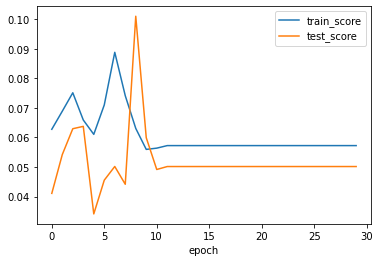

Wall time: 14min 26s


In [13]:
%%time 

train_scores = []
test_scores  = []
loss_2 = []

net = make_fc(N_FEATURES, num_layers, activation, intermediate_size)
net.apply(init_weights)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
optfunc = partial(optimize_coverage_multilinear, w = w, k=k, c = 0.95)
dgrad = partial(dgrad_coverage, w = w)
hessian = partial(hessian_coverage, w = w)
opt = ContinuousOptimizer(optfunc, dgrad, hessian, 0.95)
opt.verbose = False

print("epoch | loss | train_score | test_score ")

for epoch in range(num_epochs):
    data_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True)
    for X_batch, P_batch in data_loader:
        loss = 0 
        for X, P in zip(X_batch, P_batch):
            pred = net(X).view_as(P)
            loss += loss_fn(pred, P)
        loss = loss / batch_size
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_2.append(loss.item())

    def eval_two_stage(net, X, Y):
        return np.mean([set_func(np.argsort(- opt(net(X[i]).view_as(Y_train[0])).detach().numpy())[:k], Y[i], w) for i in range(X.shape[0])])

    train_score = eval_two_stage(net, X_train, Y_train)
    test_score  = eval_two_stage(net, X_test, Y_test)

    print(f"{epoch} | {loss} | {train_score} | {test_score}")

    train_scores.append(train_score)
    test_scores.append(test_score)

x = list(range(num_epochs))
sns.lineplot(x, train_scores, label="train_score")
sns.lineplot(x, test_scores, label="test_score")
plt.legend()
plt.xlabel("epoch")
plt.show()


### CNT

epoch | loss | train_score | test_score 
 loss :-0.057850807905197144
0 | -0.057850807905197144 | 0.06463120132684708 | 0.039006182551383974
 loss :-0.06033829599618912
1 | -0.06033829599618912 | 0.06510359048843384 | 0.05163630247116089
 loss :-0.058524295687675476
2 | -0.058524295687675476 | 0.058999452739953995 | 0.048112612962722776
 loss :-0.05864942446351051
3 | -0.05864942446351051 | 0.05875115767121315 | 0.05727651119232178
 loss :-0.057970765978097916
4 | -0.057970765978097916 | 0.057967768609523775 | 0.05643411874771118
 loss :-0.05725716054439545
5 | -0.05725716054439545 | 0.06044074296951294 | 0.058458879590034485
 loss :-0.05716206878423691
6 | -0.05716206878423691 | 0.06037365570664406 | 0.05664604902267456
 loss :-0.0571533665060997
7 | -0.0571533665060997 | 0.0602763794362545 | 0.055219563841819766
 loss :-0.057145409286022186
8 | -0.057145409286022186 | 0.060297693312168124 | 0.0556481271982193
 loss :-0.05715050548315048
9 | -0.05715050548315048 | 0.060297693312168124

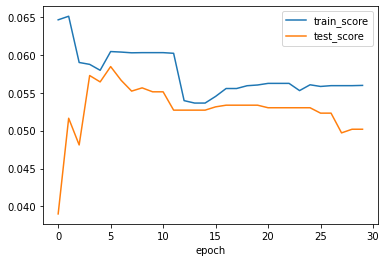

Wall time: 9min 10s


In [14]:
%%time

train_scores = []
test_scores  = []

net = make_fc(N_FEATURES, num_layers, activation, intermediate_size)
net.apply(init_weights)

optfunc = partial(optimize_coverage_multilinear, w = w, k=k, c = 0.95)
dgrad = partial(dgrad_coverage, w = w)
hessian = partial(hessian_coverage, w = w)
opt = ContinuousOptimizer(optfunc, dgrad, hessian, 0.95)
opt.verbose = False
                
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)

print("epoch | loss | train_score | test_score ")

for epoch in range(num_epochs):
    data_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True)
    for X_batch, P_batch in data_loader:
        loss = 0 
        for X, P in zip(X_batch, P_batch):
            true_cnt_func = CoverageInstanceMultilinear(P, w, True)
            pred = net(X).view_as(P)
            x = opt(pred)
            loss -= true_cnt_func(x)
        loss = loss / batch_size
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    def eval_cnt(net, X, Y):
        return np.mean([set_func(np.argsort(-opt(net(X[i]).view_as(Y_train[0])).detach().numpy())[:k], Y[i], w) for i in range(X.shape[0])])

    train_score = eval_cnt(net, X_train, Y_train)
    test_score  = eval_cnt(net, X_test, Y_test)

    print(f"{epoch} | {loss} | {train_score} | {test_score}")

    train_scores.append(train_score)
    test_scores.append(test_score)

x = list(range(num_epochs))
sns.lineplot(x, train_scores, label="train_score")
sns.lineplot(x, test_scores, label="test_score")
plt.legend()
plt.xlabel("epoch")
plt.show()

epoch | loss | train_score | test_score 
0 | -0.06076928973197937 | 0.015288348495960235 | 0.015173667669296264
1 | -0.06584206968545914 | 0.020257513225078582 | 0.007551929354667664
2 | -0.06670479476451874 | 0.01936897709965706 | 0.014478504657745361
3 | -0.05958820879459381 | 0.018799322098493575 | 0.014267870783805847
4 | -0.0570240244269371 | 0.019463644921779634 | 0.009686842560768127
5 | -0.06424318253993988 | 0.016700024902820586 | 0.01617351770401001
6 | -0.05516466125845909 | 0.01590406075119972 | 0.01883455514907837
7 | -0.059241436421871185 | 0.01871654763817787 | 0.007182687520980835
8 | -0.06418315321207047 | 0.017278300225734712 | 0.012591168284416199
9 | -0.06394138187170029 | 0.015782848000526428 | 0.018572977185249327
10 | -0.06290893256664276 | 0.01820402070879936 | 0.008294036984443665
11 | -0.05904095247387886 | 0.017835138738155364 | 0.010770317912101746
12 | -0.06015191227197647 | 0.013945347815752029 | 0.02632948160171509
13 | -0.056257180869579315 | 0.01737329438328743 | 0.009215238690376281

### Plots

In [22]:
loss_decision = [-0.06076928973197937,-0.06584206968545914,-0.06670479476451874,-0.05958820879459381,-0.0570240244269371,-0.06424318253993988,-0.05516466125845909,-0.05924143642187118,-0.06418315321207047,-0.06394138187170029,-0.06290893256664276,-0.05904095247387886,-0.06015191227197647,-0.05625718086957931,]
loss_2_stage = [0.7789968252182007, 0.7144742012023926, 0.6519206762313843, 0.5859464406967163 ,0.5397264361381531 ,0.4908316731452942 ,0.32362160086631775, 0.022119728848338127, 0.00329726655036211, 9.616058378014714e-06,  1.4370152712217532e-06]
loss_CNT = [-0.057850807905197144,-0.06033829599618912,-0.058524295687675476,-0.05864942446351051,-0.057970765978097916,-0.05725716054439545,-0.05716206878423691,-0.0571533665060997,-0.057145409286022186,-0.05715050548315048,-0.05711754783987999,]


Learning curves

(-0.08, 0.0)

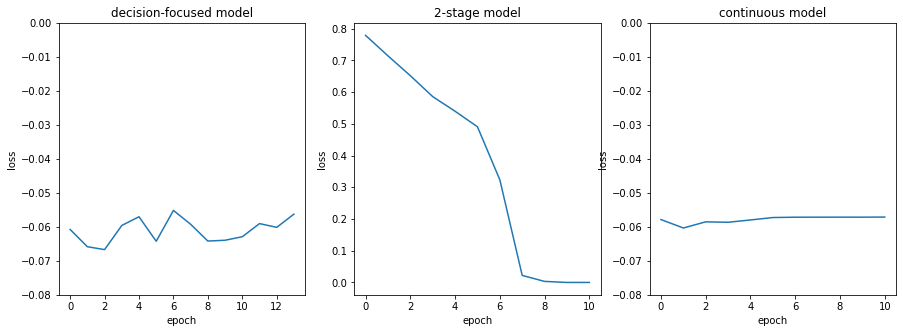

In [23]:
fig, ax = plt.subplots(1,3, figsize = (15,5))

ax[0].plot(loss_decision)
ax[0].set_title("decision-focused model")
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("loss")
ax[0].set_ylim(-0.08,0)

ax[1].plot(loss_2_stage)
ax[1].set_title("2-stage model")
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("loss")

ax[2].plot(loss_CNT)
ax[2].set_title("continuous model")
ax[2].set_xlabel("epoch")
ax[2].set_ylabel("loss")
ax[2].set_ylim(-0.08,0)


In [24]:
quality_decision_based_train=[0.015288348495960235,0.020257513225078582 ,0.01936897709965706  ,0.018799322098493575 ,.019463644921779634  ,0.016700024902820586 ,0.01590406075119972  ,0.01871654763817787  ,0.017278300225734712 ,0.015782848000526428 ,0.01820402070879936  ,0.017835138738155364 ,0.013945347815752029 ,0.01737329438328743  ]
quality_decision_based_test  = [0.015173667669296264,0.007551929354667664,0.014478504657745361,0.014267870783805847,0.009686842560768127,0.01617351770401001,0.01883455514907837,0.007182687520980835,0.012591168284416199,0.018572977185249327,0.008294036984443665,0.010770317912101746,0.02632948160171509,0.009215238690376281,]

quality_2_stage_train = [0.06274317726492881, 0.06885293275117874, 0.0750866748392582, 0.06588671803474426, 0.06102966964244842, 0.07097437083721161, 0.08876516669988632, 0.0741001047194004, 0.06304563134908676, 0.05594222992658615, 0.056365196406841275, 0.05722642466425896, 0.05722642466425896, 0.05722642466425896]
quality_2_stage_test = [0.04106912612915039,0.054186728596687314,0.06293168067932128,0.0637294352054596,0.034126061201095584,0.045535266399383545,0.050166568160057066,0.044150781631469724,0.1009661465883255,0.05989144742488861,0.04914851486682892,0.050147178769111636, 0.050147178769111636, 0.050147178769111636]

quality_CNT_train = [0.06463120132684708,0.06510359048843384  ,0.058999452739953995, 0.05875115767121315  ,0.057967768609523775 ,0.06044074296951294  ,0.06037365570664406  ,0.0602763794362545   ,0.060297693312168124 ,0.060297693312168124 ,0.060297693312168124 ,0.0602118082344532   ,0.0539618082344532   ,0.05364147499203682   ]
quality_CNT_test = [0.039006182551383974,0.05163630247116089,0.048112612962722776,0.05727651119232178,0.05643411874771118,0.058458879590034485,0.05664604902267456,0.055219563841819766,0.0556481271982193,0.05512729585170746,0.05512729585170746,0.05270652174949646,0.05270652174949646,0.05270652174949646]


Decision quality

The decision quality is the maximum influence, estimated by optimization methods.

Text(0.5, 0, 'epoch')

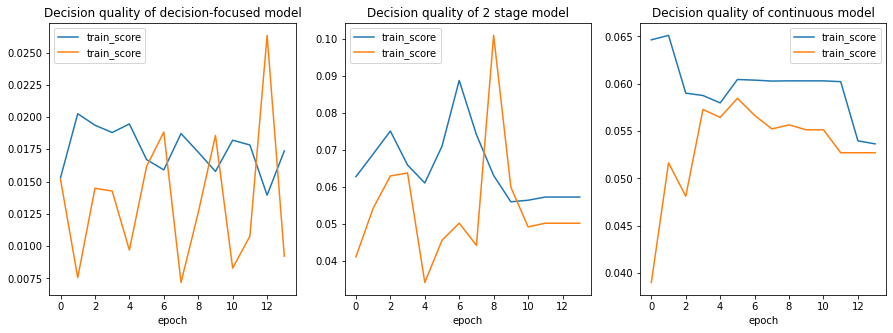

In [20]:
fig, ax = plt.subplots(1,3, figsize = (15,5))

ax[0].plot(quality_decision_based_train, label = "train_score")
ax[0].plot(quality_decision_based_test, label = "train_score")
ax[0].set_title("Decision quality of decision-focused model")
ax[0].legend()
ax[0].set_xlabel("epoch")

ax[1].plot(quality_2_stage_train, label = "train_score")
ax[1].plot(quality_2_stage_test, label = "train_score")
ax[1].set_title("Decision quality of 2 stage model")
ax[1].legend()
ax[1].set_xlabel("epoch")

ax[2].plot(quality_CNT_train, label = "train_score")
ax[2].plot(quality_CNT_test, label = "train_score")
ax[2].set_title("Decision quality of continuous model")
ax[2].legend()
ax[2].set_xlabel("epoch")


